In [1]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

c:\users\aditya pandey\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con1 = sqlite3.connect("database.sqlite")

filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000", con1)

def polarity(x):
    
    if x > 3:
        return "positive"
    return "negetive"

actualScore = filtered_data["Score"]
positive_negetive = actualScore.map(polarity)
filtered_data["Score"] = positive_negetive

print(filtered_data.shape)

(5000, 10)


## Data Cleaning - Deduplication

In [3]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
((final.shape[0]*1.0)/(filtered_data.shape[0]*1.0)*100)

(4986, 10)


99.72

In [4]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

print(final.shape)


(4986, 10)


## Stemming, StopWord Removal and Lemmatization

In [5]:
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [6]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [7]:
final["CleanedText"] = final_string
final["CleanedText"] = final["CleanedText"].str.decode("utf-8")
print(final.shape)

(4986, 11)


In [8]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,positive,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product avail www amazon com victor trap unrea...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,positive,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,use victor fli bait season cant beat great pro...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...


In [9]:
my_final = final
my_final.shape

(4986, 11)

In [10]:
my_final.sort_values("Time", inplace = True)

In [11]:
x = my_final['CleanedText'].values

In [12]:
x.shape

(4986,)

## BoW implementation

In [13]:
count_vect = CountVectorizer(min_df = 10)
data = count_vect.fit_transform(x)
print(type(data))
print(data.get_shape())
print("Number o unique words: ", data.get_shape()[1])

<class 'scipy.sparse.csr.csr_matrix'>
(4986, 1854)
Number o unique words:  1854


In [14]:
from sklearn.cluster import KMeans

k_values = [2,4,6,8,10,12,14,16,18,20]

loss = []

for i in k_values:
    kmeans = KMeans(n_clusters = i, n_jobs= -1).fit(data)
    loss.append(kmeans.inertia_)

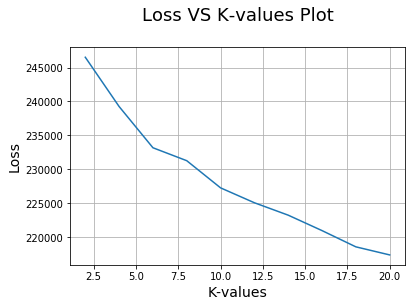

In [15]:
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [16]:
optimal_k = 4

bow_means_k = optimal_k

kmeans = KMeans(n_clusters = optimal_k, n_jobs = -1).fit(data)

In [17]:
reviews = my_final["Text"].values

cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []

for i in range(kmeans.labels_.shape[0]):
    
    if kmeans.labels_[i]==0:
        cluster_1.append(reviews[i])
        
    elif kmeans.labels_[i]==1:
        cluster_2.append(reviews[i])
    
    elif kmeans.labels_[i]==2:
        cluster_3.append(reviews[i])
    
    else:
        cluster_4.append(reviews[i])
        
print("No. of reviews in cluster 1", len(cluster_1))
print("No. of reviews in cluster 2", len(cluster_2))
print("No. of reviews in cluster 3", len(cluster_3))
print("No. of reviews in cluster 4", len(cluster_4))
        
    

No. of reviews in cluster 1 130
No. of reviews in cluster 2 536
No. of reviews in cluster 3 188
No. of reviews in cluster 4 4132


In [18]:
text_cluster_1 = "".join(cluster_1)
print(type(text_cluster_1))

<class 'str'>


In [19]:
# https://python-graph-gallery.com/260-basic-wordcloud/
from wordcloud import WordCloud

wordcloud = WordCloud(width = 480, height = 480, margin = 0).generate(text_cluster_1)

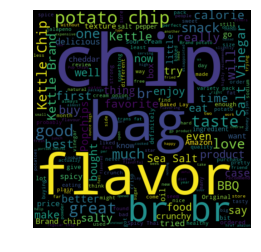

In [20]:
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

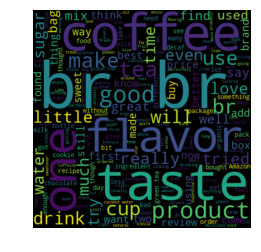

In [21]:
text_cluster_2 = "".join(cluster_2)

wordcloud = WordCloud(width = 480, height = 480, margin=0).generate(text_cluster_2)

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

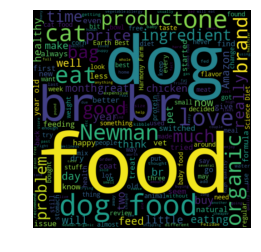

In [22]:
text_cluster_3 = "".join(cluster_3)

wordcloud = WordCloud(width = 480, height = 480, margin=0).generate(text_cluster_3)

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

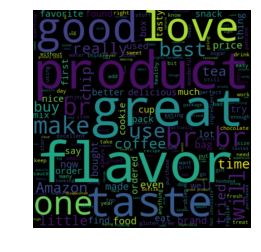

In [23]:
text_cluster_4 = "".join(cluster_4)

wordcloud = WordCloud(width = 480, height = 480, margin=0).generate(text_cluster_4)

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

## Agglomerative Clustering

In [33]:
type(data)

numpy.matrixlib.defmatrix.matrix

In [34]:
len(data)

4986

In [36]:
from sklearn.cluster import AgglomerativeClustering

reviews = my_final["Text"].values

clustering = AgglomerativeClustering(n_clusters = 5).fit(data)

print(clustering.labels_)

[2 2 2 ... 2 0 2]


In [37]:
len(clustering.labels_)

4986

In [38]:
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []
cluster_5 = []

n = len(clustering.labels_)
print(n)

for index in range(n):
    
    if clustering.labels_[index] == 0:
        cluster_1.append(reviews[index])
        
    elif clustering.labels_[index] == 1:
        cluster_2.append(reviews[index])
        
    elif clustering.labels_[index] == 2:
        cluster_3.append(reviews[index])
    
    elif clustering.labels_[index] == 3:
        cluster_4.append(reviews[index])
        
    else:
        cluster_5.append(reviews[index])
        
        

4986


In [40]:
print("Number of reviews in cluster 1: ", len(cluster_1))
print("Number of reviews in cluster 2: ", len(cluster_2))
print("Number of reviews in cluster 3: ", len(cluster_3))
print("Number of reviews in cluster 4: ", len(cluster_4))
print("Number of reviews in cluster 5: ", len(cluster_5))

Number of reviews in cluster 1:  694
Number of reviews in cluster 2:  48
Number of reviews in cluster 3:  4171
Number of reviews in cluster 4:  25
Number of reviews in cluster 5:  48


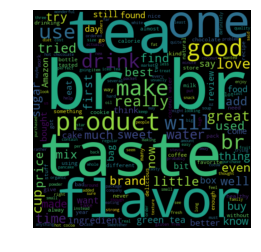

In [44]:
text_cluster_1 = "".join(cluster_1)

wordcloud = WordCloud(width = 480, height = 480, margin=0).generate(text_cluster_1)

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

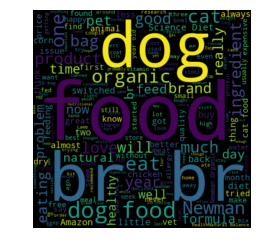

In [45]:
text_cluster_2 = "".join(cluster_2)

wordcloud = WordCloud(width = 480, height = 480, margin=0).generate(text_cluster_2)

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

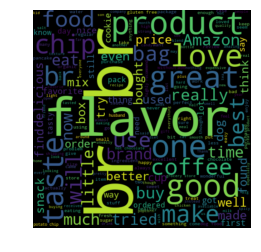

In [46]:
text_cluster_3 = "".join(cluster_3)

wordcloud = WordCloud(width = 480, height = 480, margin=0).generate(text_cluster_3)

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

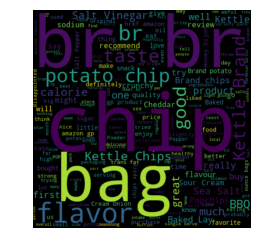

In [47]:
text_cluster_4 = "".join(cluster_4)

wordcloud = WordCloud(width = 480, height = 480, margin=0).generate(text_cluster_4)

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

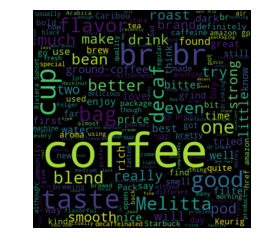

In [48]:
text_cluster_5 = "".join(cluster_5)

wordcloud = WordCloud(width = 480, height = 480, margin=0).generate(text_cluster_5)

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()